<a href="https://colab.research.google.com/github/ravi0dubey/Transfer_Learning-Resnet/blob/main/Transfer_Learning_Resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Aug 14 21:29:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [3]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
ROOT_PATH = '/content/drive/MyDrive/VGGNet'

In [6]:
!pwd

/content


In [7]:
import os
os.chdir(ROOT_PATH)
os.getcwd()

'/content/drive/MyDrive/VGGNet'

In [8]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Flowers/train'
valid_path = 'Flowers/validation'


In [9]:
# Download Resnet50 model
# Here we will be using imagenet weights for the Resnet architecture
# we will add number of channel, which is 3, to our image. Post adding channel input_shape becomes =(224,224,3)

resnet50 = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


In [10]:
# Print list of all layers of Resnet architecture
for layer in resnet50.layers:
  print(layer)

In [11]:
# don't train existing weights
for layer in resnet50.layers:
    layer.trainable = False

In [12]:
# Print to see how many layers of Resnet are trainable
for layer in resnet50.layers:
  print(layer.name,layer.trainable)

input_1 False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_1_bn False
conv3_block1_1_relu False
conv3_block1_2_con

In [13]:
resnet50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [14]:
  # It will provide list of all folders whithin the flowers class
  # useful for getting number of output classes
folders = glob('Flowers/train/*')

In [15]:
# Folder variable stores all the folders within train class
folders

['Flowers/train/daisy',
 'Flowers/train/tulip',
 'Flowers/train/dandelion',
 'Flowers/train/rose',
 'Flowers/train/sunflower']

In [16]:
# Number of folders within train class is 5
len(folders)

5

In [17]:
# creating the architecture  by adding resnet50 at top
# Add Flatten Layer
# Add Dense layer1 which has 256 neurons. Activation function is Relu
# Add Dense layer2 which act as classification layer. It has 5 neurons as we have 5 output classes. Activation is softmax

model = Sequential()

model.add(resnet50)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

In [18]:
# view the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 49,279,365
Trainable params: 25,691,653
Non-trainable params: 23,587,712
_________________________________________________________________


In [19]:
# Tell the model what cost and optimization method to use
# Loss is Categorical cross Entropy

# optimizer used is Adam
# metrics = Accuracy

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [20]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [21]:
!pwd

/content/drive/MyDrive/VGGNet


In [22]:
# Make sure you provide the same target size as initialied for the image size

training_set = train_datagen.flow_from_directory('Flowers/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1600 images belonging to 5 classes.


In [23]:
test_set = test_datagen.flow_from_directory('Flowers/validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 300 images belonging to 5 classes.


In [24]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
50/50 [==============================] - 44s 596ms/step - loss: 8.1881 - accuracy: 0.5556 - val_loss: 3.5263 - val_accuracy: 0.2533
Epoch 2/20
50/50 [==============================] - 25s 498ms/step - loss: 1.6387 - accuracy: 0.6400 - val_loss: 2.1798 - val_accuracy: 0.4067
Epoch 3/20
50/50 [==============================] - 25s 489ms/step - loss: 1.6751 - accuracy: 0.6187 - val_loss: 4.9270 - val_accuracy: 0.2333
Epoch 4/20
50/50 [==============================] - 25s 509ms/step - loss: 1.7325 - accuracy: 0.6438 - val_loss: 5.2999 - val_accuracy: 0.2633
Epoch 5/20
50/50 [==============================] - 25s 502ms/step - loss: 1.2074 - accuracy: 0.6931 - val_loss: 3.2719 - val_accuracy: 0.3267
Epoch 6/20
50/50 [==============================] - 25s 491ms/step - loss: 1.0363 - accuracy: 0.7156 - val_loss: 2.7330 - val_accuracy: 0.3833
Epoch 7/20
50/50 [==============================] - 24s 478ms/step - loss: 1.0256 - accuracy: 0.7206 - val_loss: 1.8433 - val_accuracy: 0.4733

In [25]:
import matplotlib.pyplot as plt

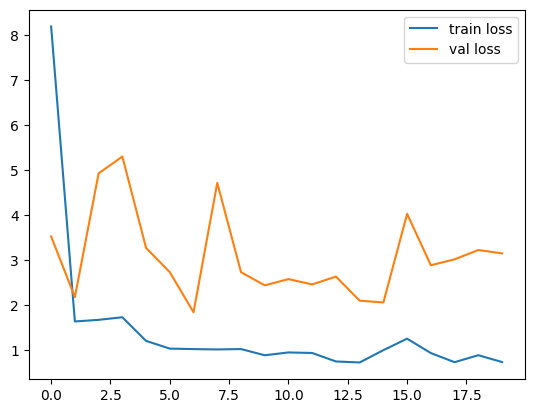

<Figure size 640x480 with 0 Axes>

In [26]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

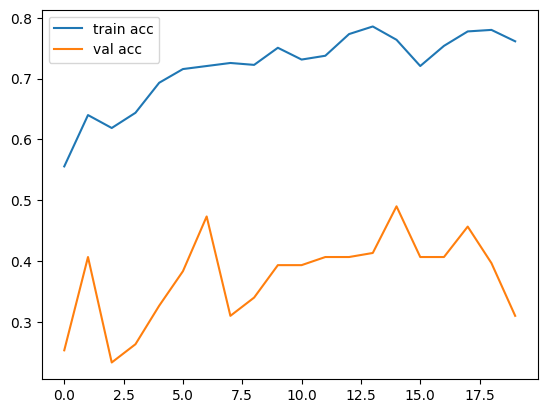

<Figure size 640x480 with 0 Axes>

In [27]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [28]:
# save it as a h5 file
from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

In [29]:
y_pred = model.predict(test_set)

10/10 [==============================] - 2s 129ms/step


In [30]:
y_pred

array([[6.5559524e-01, 1.3567495e-01, 1.4578955e-01, 1.0084534e-04,
        6.2839396e-02],
       [9.7283316e-01, 8.0063372e-05, 2.5658477e-02, 5.1402607e-05,
        1.3768993e-03],
       [1.0000000e+00, 2.6092533e-12, 1.5612860e-17, 3.1904821e-14,
        2.1342449e-17],
       ...,
       [7.3950309e-01, 4.1738153e-05, 2.5915965e-01, 1.9799631e-05,
        1.2757735e-03],
       [3.6736518e-01, 7.8649726e-03, 5.0992149e-01, 9.4482553e-04,
        1.1390351e-01],
       [3.1598276e-03, 1.5697753e-03, 6.3529082e-02, 8.7882370e-07,
        9.3174040e-01]], dtype=float32)

In [31]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [32]:
y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 1, 2, 4, 0, 0,
       0, 2, 0, 2, 0, 0, 1, 2, 4, 0, 0, 4, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0,
       0, 0, 2, 0, 0, 0, 0, 2, 4, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 2, 4, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 2, 0, 4, 0, 0, 2, 2, 4, 4, 0, 0, 0, 0, 0, 0, 4,
       4, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 2, 2, 4, 0, 0, 1, 0, 0, 0, 2, 0,
       1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 3, 2, 0, 2, 0, 2, 4, 0, 0, 4, 2, 0, 2, 0, 0, 0, 2,
       4, 0, 0, 2, 2, 4, 0, 2, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 4, 0, 0, 2, 0, 0, 2, 0, 4, 0, 4, 0, 0, 2, 0, 0, 2, 0, 0,
       1, 1, 0, 3, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4,
       0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 1, 2, 4, 0, 2, 0,
       0, 0, 2, 0, 2, 4, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4])

In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [34]:
# in case we need to used the saved model for prediction

# model=load_model('model_resnet50.h5')

In [35]:
img=image.load_img('tulip.jpg',target_size=(224,224))

In [36]:
x=image.img_to_array(img)
x

array([[[215.,  87.,  12.],
        [221., 108.,  14.],
        [224., 116.,  15.],
        ...,
        [102.,  22.,  15.],
        [103.,  22.,  18.],
        [114.,  20.,  20.]],

       [[219.,  83.,  21.],
        [219.,  98.,  17.],
        [223., 108.,  19.],
        ...,
        [102.,  18.,  16.],
        [100.,  19.,  16.],
        [107.,  17.,  19.]],

       [[219.,  73.,  26.],
        [224.,  93.,  25.],
        [222.,  96.,  20.],
        ...,
        [101.,  15.,  18.],
        [ 98.,  16.,  18.],
        [ 99.,  14.,  17.]],

       ...,

       [[156.,  16.,  19.],
        [153.,  17.,  17.],
        [153.,  15.,  15.],
        ...,
        [ 91.,  17.,  14.],
        [ 89.,  18.,  14.],
        [ 90.,  19.,  15.]],

       [[158.,  15.,  19.],
        [155.,  17.,  17.],
        [153.,  15.,  15.],
        ...,
        [ 86.,  17.,  12.],
        [ 86.,  17.,  10.],
        [ 90.,  21.,  14.]],

       [[159.,  14.,  19.],
        [156.,  18.,  18.],
        [154.,  

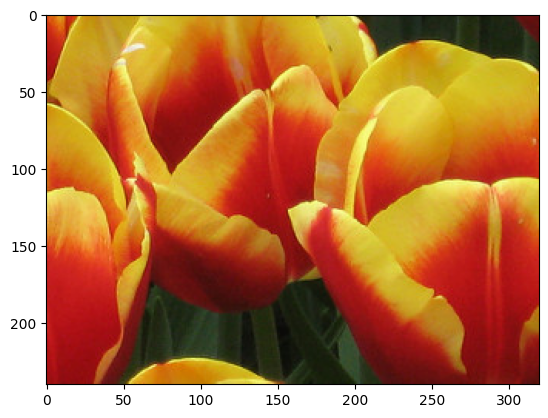

In [37]:
Z = plt.imread('tulip.jpg')
plt.imshow(Z)

In [38]:
x.shape

(224, 224, 3)

In [39]:
x=x/255

In [40]:
from keras.applications.vgg16 import preprocess_input

In [41]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [42]:
model.predict(img_data)

1/1 [==============================] - 1s 1s/step


array([[9.9999475e-01, 6.0584460e-07, 4.0972599e-12, 4.6114783e-06,
        8.9262324e-14]], dtype=float32)

In [43]:
a=np.argmax(model.predict(img_data), axis=1)

1/1 [==============================] - 0s 24ms/step


In [44]:
a

array([0])

In [45]:
flower_name = ['dandelion',
 'sunflower',
 'tulip',
 'daisy',
 'rose']

In [46]:
flower_name[a[0]]

'dandelion'

Prediction is not correct as we had to train our model on more data set
